# Simple 1010 Pattern

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

## Data Functions

In [2]:
# function to generate real data

def generate_real():
    real_data = mindspore.Tensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)], mindspore.float32)
    return real_data

In [3]:
generate_real()

Tensor(shape=[4], dtype=Float32, value= [ 8.59873950e-01,  5.64498231e-02,  9.21470821e-01,  6.21404089e-02])

In [4]:
# function to generate uniform random data

def generate_random(size):
    random_data = mindspore.Tensor(numpy.random.rand(size), mindspore.float32)
    return random_data

In [5]:
generate_random(4)

Tensor(shape=[4], dtype=Float32, value= [ 5.87776899e-01,  8.54252815e-01,  1.67392999e-01,  6.90094829e-01])

## Discriminator Network

In [6]:
# discriminator class

class Discriminator(nn.Cell):
    
    def __init__(self):
        # initialise parent cell class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(4, 3),
            nn.Sigmoid(),
            nn.Dense(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimizer, simple stochastic gradient descent
        self.optimizer = nn.SGD(self.trainable_params(), learning_rate=0.05)
        
        self.model_with_loss = nn.WithLossCell(self.model, self.loss_function)
        self.model_train = nn.TrainOneStepCell(self.model_with_loss, self.optimizer)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

    def construct(self, inputs):
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)

    def train(self, inputs, targets):
        # train one step
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Test Discriminator

In [7]:
# test discriminator can separate real data from random noise

D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real().reshape(1, -1), mindspore.Tensor([[1.0]], mindspore.float32))
    # fake data
    D.train(generate_random(4).reshape(1, -1), mindspore.Tensor([[0.0]], mindspore.float32))


counter =  10000
counter =  20000


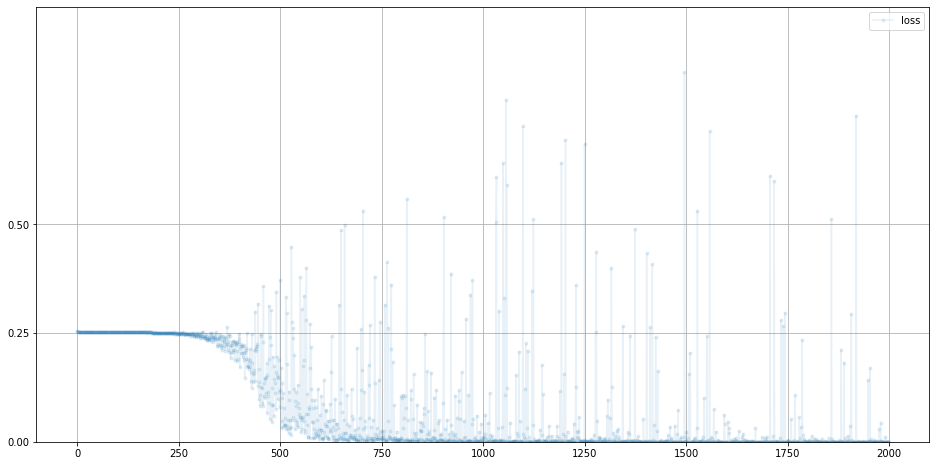

In [8]:
# plot discriminator loss

D.plot_progress()

In [9]:
# manually run discriminator to check it can tell real data from fake

print( D.construct( generate_real() ).asnumpy().item() )
print( D.construct( generate_random(4) ).asnumpy().item() )

0.9316080808639526
0.014704041182994843


## Generator Network

In [10]:
# generator class

class Generator(nn.Cell):
    
    def __init__(self, D_with_loss):
        # initialise parent cell class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(1, 3),
            nn.Sigmoid(),
            nn.Dense(3, 4),
            nn.Sigmoid()
        )

        self.loss_fn = D_with_loss
        
        # create optimizer, simple stochastic gradient descent
        self.optimizer = nn.SGD(self.trainable_params(), learning_rate=0.05)
        
        self.model_train = mindspore.build_train_network(self.model, self.optimizer, loss_fn=self.loss_fn)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    def construct(self, inputs):        
        # simply run model
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)

    def train(self, inputs, targets):
        # calculate error
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Test Generator Output

In [11]:
# check the generator output is of the right type and shape

G = Generator(D.model_with_loss)

G.construct(mindspore.Tensor([0.5], mindspore.float32))

Tensor(shape=[4], dtype=Float32, value= [ 5.00697315e-01,  5.00057161e-01,  4.98958260e-01,  5.01136780e-01])

## Train GAN

In [12]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator(D.model_with_loss)

image_list = []

# train Discriminator and Generator

for i in range(10000):
    # batch_size 1
    input_seed = mindspore.Tensor([[0.5]], mindspore.float32)
    label_true = mindspore.Tensor([[1.0]], mindspore.float32)
    label_false = mindspore.Tensor([[0.0]], mindspore.float32)
    
    # train discriminator on true
    D.train(generate_real().reshape(1, -1), label_true)
    
    # train discriminator on false
    D.train(G.construct(input_seed), label_false)
    
    # train generator
    G.train(input_seed, label_true)
    
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.construct(input_seed)[0].asnumpy() )


counter =  10000
counter =  20000
CPU times: user 36.7 s, sys: 13.4 s, total: 50.1 s
Wall time: 40.1 s


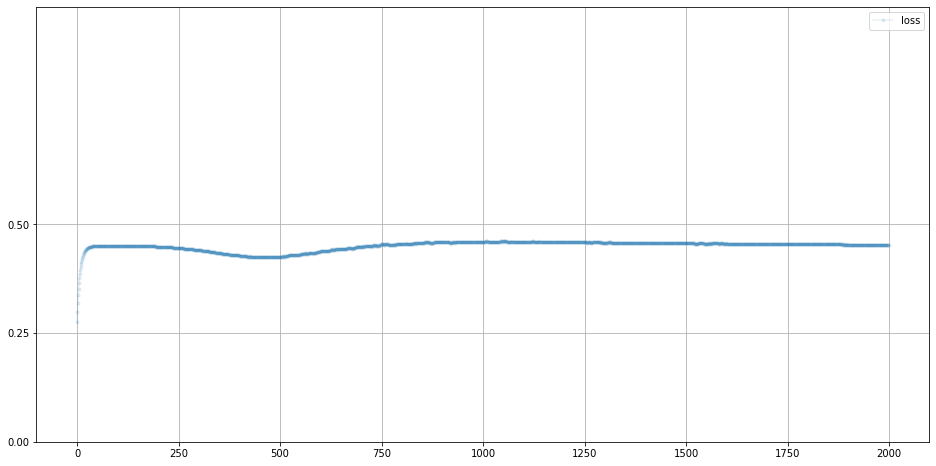

In [13]:
# plot discriminator error

D.plot_progress()

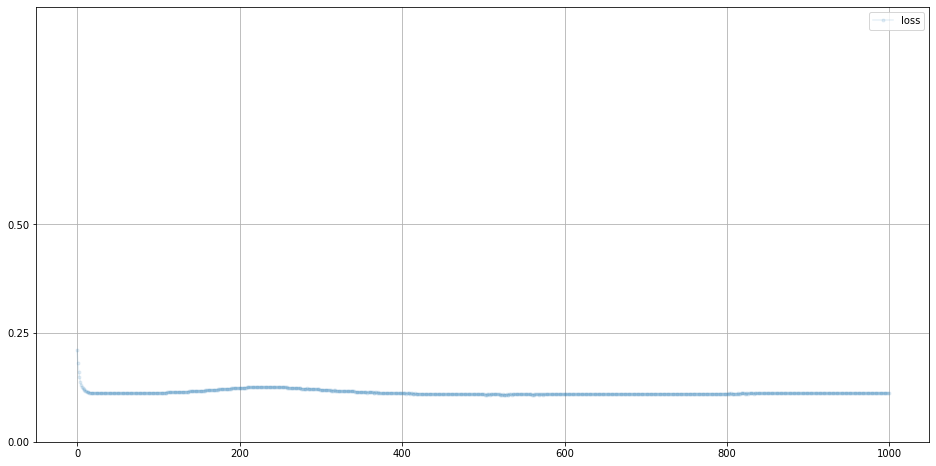

In [14]:
# plot generator error

G.plot_progress()

## Manually Run Generator

In [15]:
# manually run generator to see it's outputs

G.construct(mindspore.Tensor([0.5], mindspore.float32))

Tensor(shape=[4], dtype=Float32, value= [ 9.69303131e-01,  2.38597877e-02,  9.69235599e-01,  2.38773953e-02])

## Visualise Pattern During Training

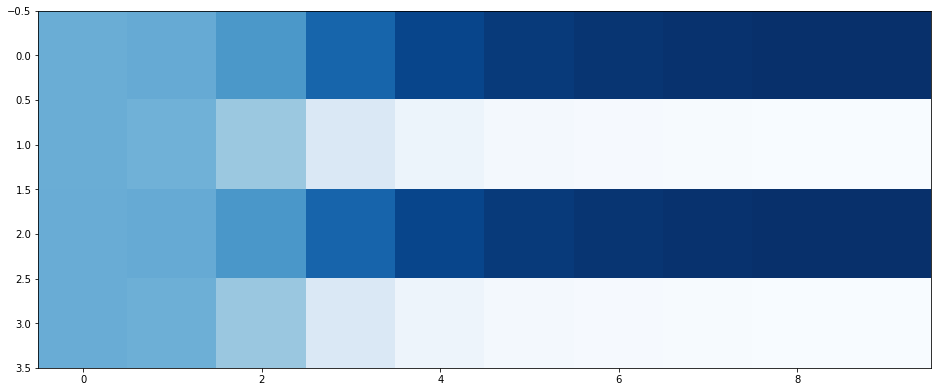

In [16]:
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')